# Determinación de umbrales óptimos

## Curvas umbral coste para matriz de costes fija y prob a priori fija

En este cuaderno realizaremos un estudio para a partir de:
* los scores de cada clase de validación y su correspondiente GT
* La probabilidad a priori de que cada defecto esté presente
* Una matriz de costes de los errores de 2 x 2
    * Coste de decidir defecto ausente cuando realmente está ausente : $C_{00}$. Normalmente $C_{00}=0$
    * Coste de decidir defecto presente cuando realmente está ausente : $C_{10}$. 

    * Coste de decidir defecto ausente cuando realmente está presente : $C_{01}$. 
    * Coste de decidir defecto presente cuando realmente está presente : $C_{11}$. 
    Normalmente $C_{11}=0$

$$ \left(\begin{array}{cc}
C_{00} & C_{01} \\
C_{10} & C_{11} 
\end{array} 
\right)  
$$

determinaremos curvas para ver:
* El coste para cada defecto en función del umbral
* El mínimo de la curva corresponderá al umbral óptimo    


In [28]:
import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

In [29]:
current_file_dir = os.getcwd()
train_results_json="../out_evaluate_patch_224_reanot4/train_scores.json"
val_results_json="../out_evaluate_patch_224_reanot4/val_scores.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    




def create_tables(train_data,clases):
    labels=[]
    preds=[]
    filenames=[]
    for d in train_data:
        truth=[]
        pred=[]
        gt=d['ground_truth']
        scores=d['scores']
        d['filename']
        for defecto in clases:
            truth.append(gt[defecto])
            pred.append(scores[defecto])
        labels.append(truth)
        preds.append(pred)
        filenames.append(d['filename'])
            
    labels=torch.tensor(labels)
    preds=torch.tensor(preds)

    return preds,labels,filenames


with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

1045
279


In [30]:
preds_train,labels_train,filenames_train=create_tables(train_data,clases)
preds_val,labels_val,filenames_val=create_tables(val_data,clases)
print(len(filenames_val))

279


In [31]:
costes=np.array([[0,1],[1,0]]) # En principio la misma para cada defecto
prob_a_priori=np.ones(len(clases))*0.05 # Probabilidad a priori de cada clase

print(costes)
print(clases)
print(prob_a_priori)
umbrales=np.linspace(0,1,100)

[[0 1]
 [1 0]]
['green', 'hollow', 'light_scars', 'oil_spots', 'plu_stickers', 'rotten', 'scars', 'skin_breakdown', 'surface']
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


In [32]:
ndefectos=len(clases)

costes_clases=[]
for k in range(ndefectos):
    scores=preds_val[:,k].numpy()
    labels=labels_val[:,k].numpy()
    
    scorespos=scores[labels>0.5]
    scoresneg=scores[labels<=0.5]
    print(f"{clases[k]}: {len(scorespos)} positivos, {len(scoresneg)} negativos")
    costes_clase=[]
    for u in umbrales:
        prob00=np.mean((scoresneg<=u))
        prob10=np.mean(scoresneg>u)
        prob01=np.mean(scorespos<=u)
        prob11=np.mean(scorespos>u)
        P1=prob_a_priori[k]
        P0=1-P1
        coste=P0*prob00*costes[0,0]+P1*prob01*costes[0,1]+P0*prob10*costes[1,0]+P1*prob11*costes[1,1]
        costes_clase.append(coste)
    costes_clase=np.array(costes_clase)
    costes_clases.append(costes_clase)

green: 29 positivos, 250 negativos
hollow: 9 positivos, 270 negativos
light_scars: 33 positivos, 246 negativos
oil_spots: 14 positivos, 265 negativos
plu_stickers: 8 positivos, 271 negativos
rotten: 22 positivos, 257 negativos
scars: 26 positivos, 253 negativos
skin_breakdown: 20 positivos, 259 negativos
surface: 81 positivos, 198 negativos


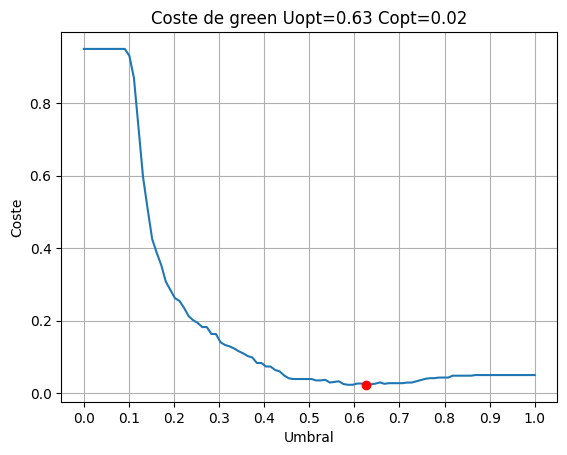

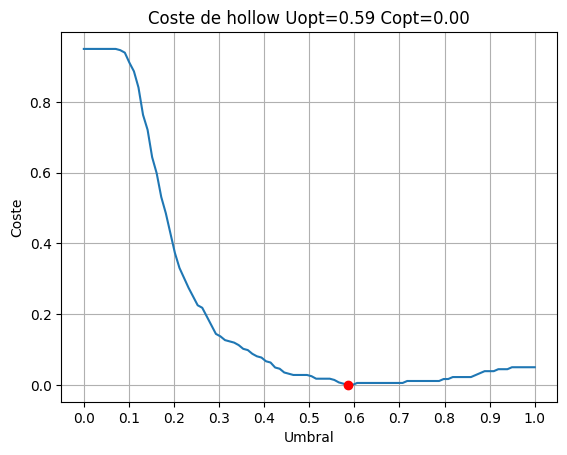

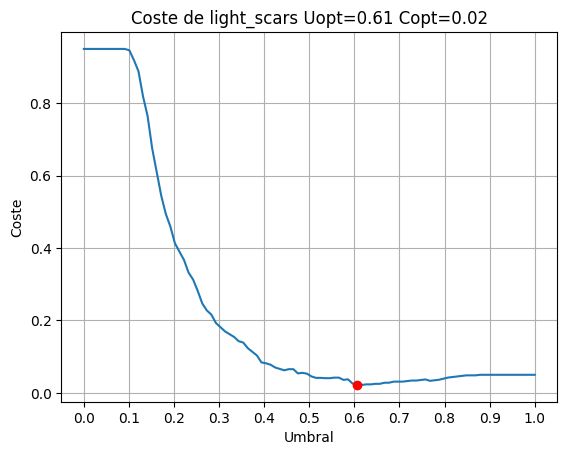

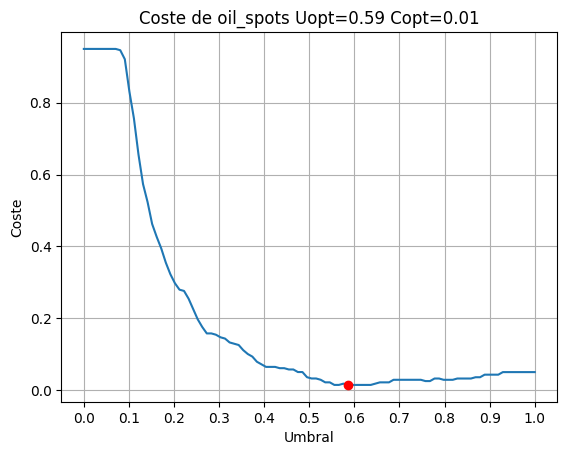

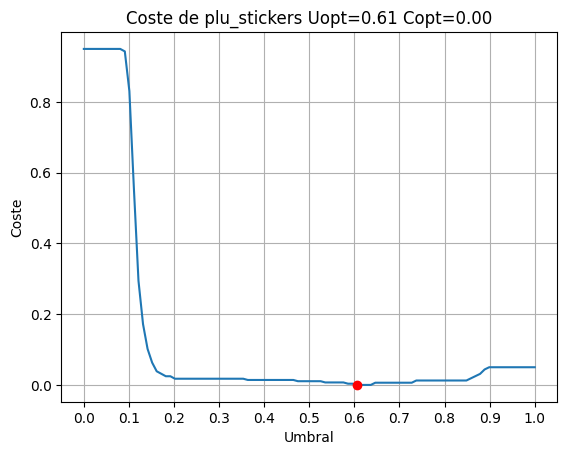

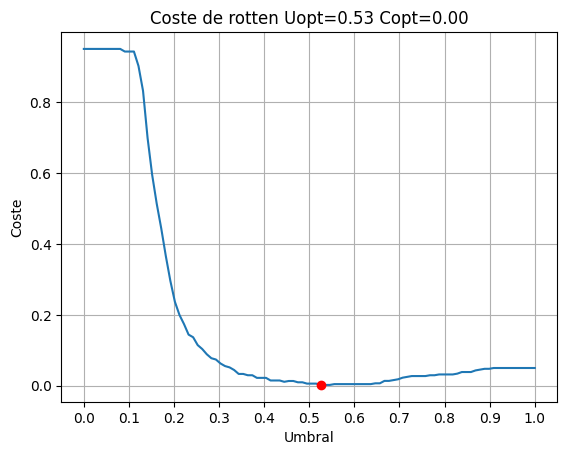

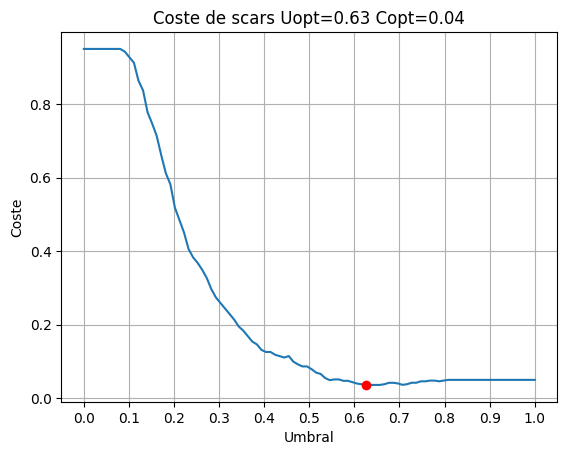

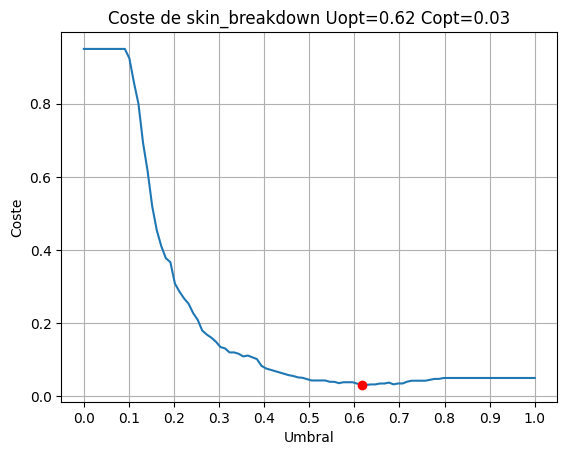

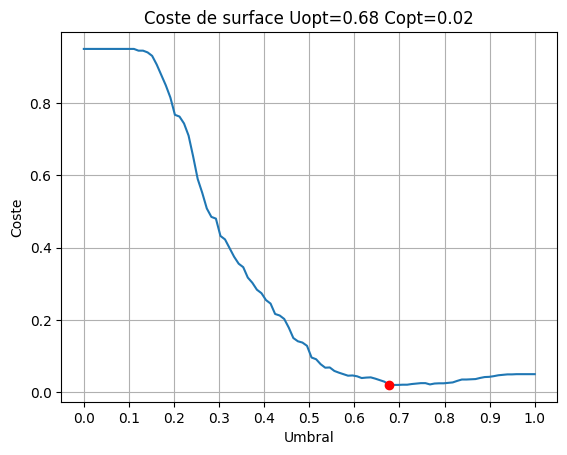

In [33]:
for i in range(ndefectos):
    _=plt.figure()
    plt.plot(umbrales, costes_clases[i])

    kmin=np.argmin(costes_clases[i])
    _=plt.plot(umbrales[kmin], costes_clases[i][kmin], 'ro')
    _=plt.xlabel("Umbral")
    _=plt.ylabel("Coste")
    _=plt.title(f"Coste de {clases[i] } Uopt={umbrales[kmin]:.2f} Copt={costes_clases[i][kmin]:.2f}")
    _=plt.xticks(np.arange(0, 1.1, 0.1))
    _=plt.grid()


# Variación del umbrall óptimo de cada clase, en función de la probabilidad de defecto de cada clase

In [34]:
umbrales

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [35]:
ndefectos=len(clases)


umbrales_clases=[]
probs_a_priori=np.arange(0.01,0.2,0.01)

for k in range(ndefectos):
    scores=preds_val[:,k].numpy()
    labels=labels_val[:,k].numpy()
    
    scorespos=scores[labels>0.5]
    scoresneg=scores[labels<=0.5]
    umbrales_clase=[]
    print(f"{clases[k]}: {len(scorespos)} positivos, {len(scoresneg)} negativos")
    for probabilidad_a_priori in probs_a_priori:

        costes_clase=[]
        for u in umbrales:
            prob00=np.mean((scoresneg<=u))
            prob10=np.mean(scoresneg>u)
            prob01=np.mean(scorespos<=u)
            prob11=np.mean(scorespos>u)
            P1=probabilidad_a_priori
            P0=1-P1
            coste=P0*prob00*costes[0,0]+P1*prob01*costes[0,1]+P0*prob10*costes[1,0]+P1*prob11*costes[1,1]
            costes_clase.append(coste)
        costes_clase=np.array(costes_clase)
        imax=np.argmin(costes_clase)
        uopt=umbrales[imax]
        #print(f"Probabilidad a priori {probabilidad_a_priori:.2f} Uopt={uopt:.2f} Copt={costes_clase[imax]:.2f}")
        umbrales_clase.append(uopt)
    
    umbrales_clases.append(umbrales_clase)
    

green: 29 positivos, 250 negativos
hollow: 9 positivos, 270 negativos
light_scars: 33 positivos, 246 negativos
oil_spots: 14 positivos, 265 negativos
plu_stickers: 8 positivos, 271 negativos
rotten: 22 positivos, 257 negativos
scars: 26 positivos, 253 negativos
skin_breakdown: 20 positivos, 259 negativos
surface: 81 positivos, 198 negativos


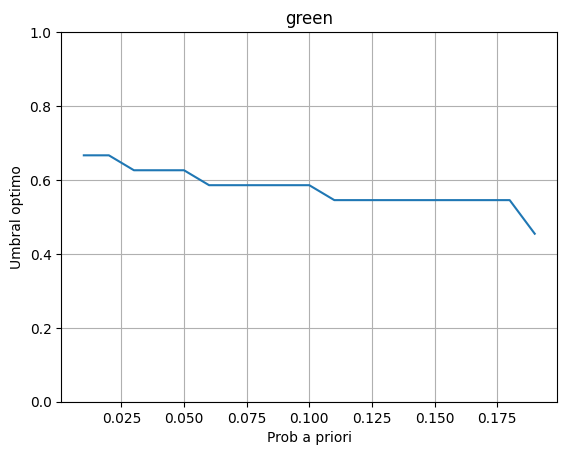

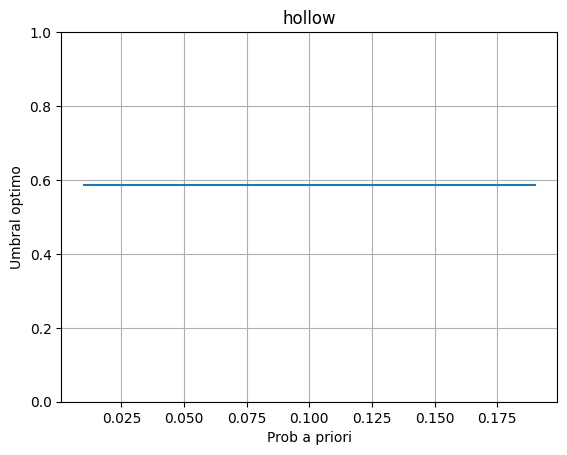

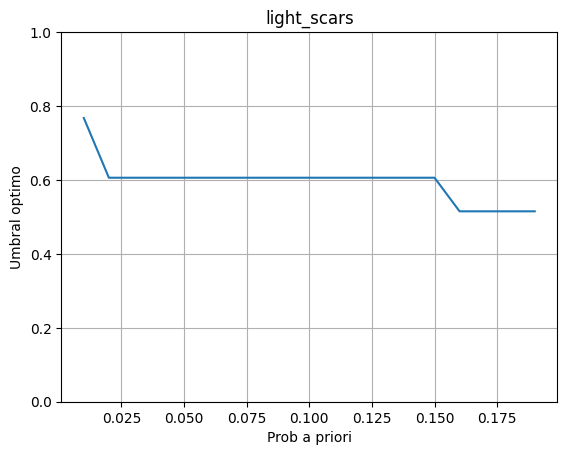

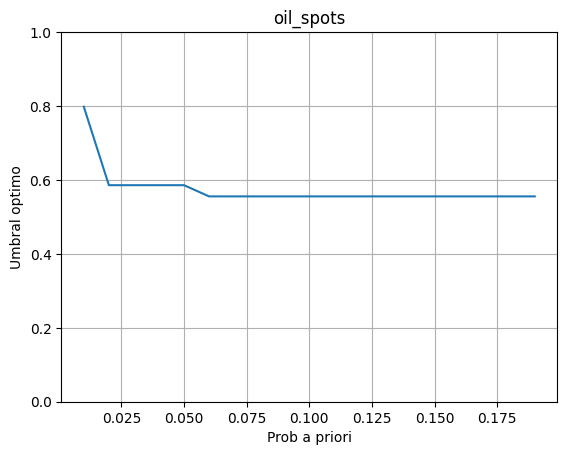

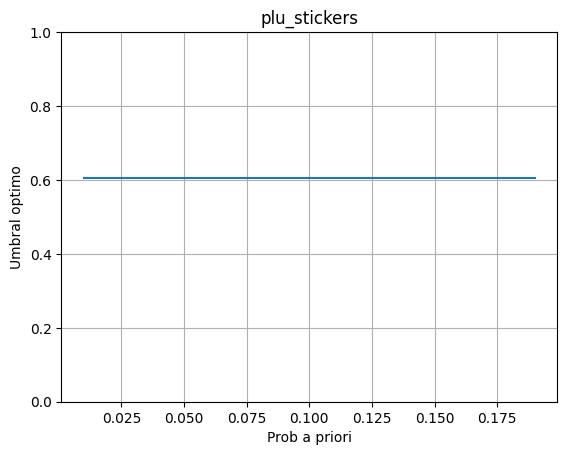

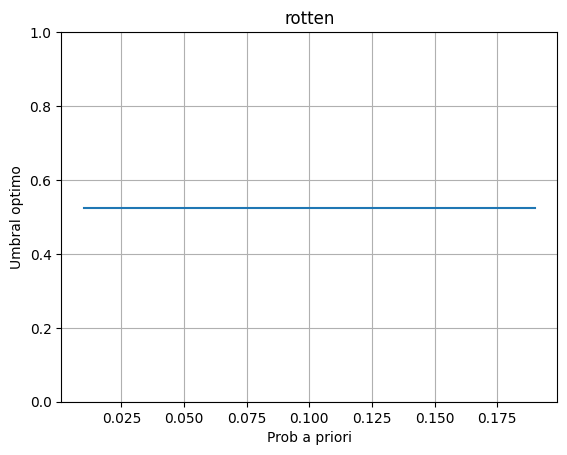

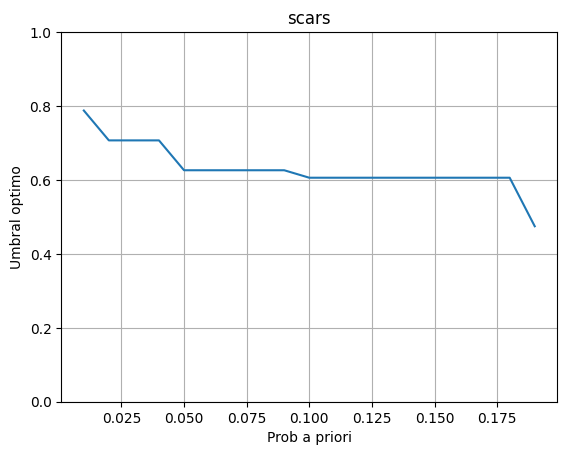

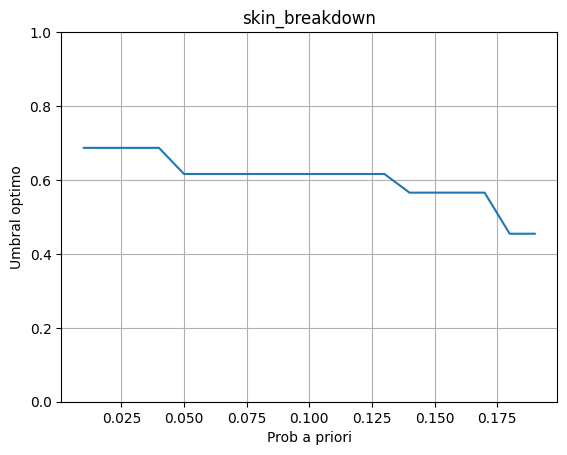

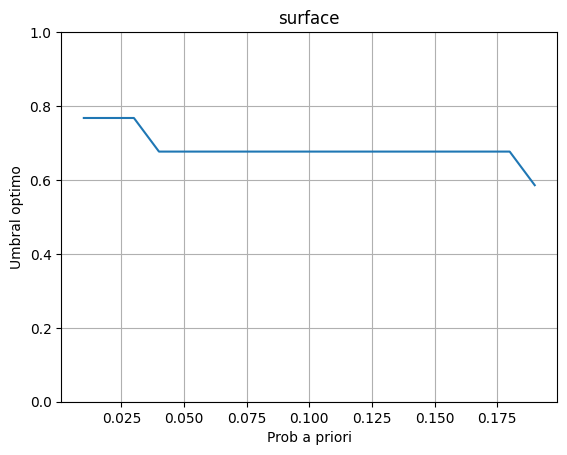

In [36]:
for i in range(ndefectos):
    _=plt.figure()
    plt.plot(probs_a_priori, umbrales_clases[i])
    _=plt.xlabel("Prob a priori")
    _=plt.ylabel("Umbral optimo")
    _=plt.title(f"{clases[i] }")
    _=plt.ylim(0,1)
    _=plt.grid()


# Variación del umbral óptimo para distintos costes del falso negativo

## Coste Falsa Alarma = 1

In [37]:
ndefectos=len(clases)


umbrales_clases=[]
prob_a_priori=0.1

costes_falso_negativos=np.linspace(0.3,3,25)

for k in range(ndefectos):
    scores=preds_val[:,k].numpy()
    labels=labels_val[:,k].numpy()
    
    scorespos=scores[labels>0.5]
    scoresneg=scores[labels<=0.5]
    umbrales_clase=[]
    print(f"{clases[k]}: {len(scorespos)} positivos, {len(scoresneg)} negativos")
    for coste_falso_negativo in costes_falso_negativos:

        costes_clase=[]
        for u in umbrales:
            prob00=np.mean((scoresneg<=u))
            prob10=np.mean(scoresneg>u)
            prob01=np.mean(scorespos<=u)
            prob11=np.mean(scorespos>u)
            P1=probabilidad_a_priori
            P0=1-P1
            coste=P0*prob00*costes[0,0]+P1*prob01*coste_falso_negativo+P0*prob10*costes[1,0]+P1*prob11*costes[1,1]
            costes_clase.append(coste)
        costes_clase=np.array(costes_clase)
        imax=np.argmin(costes_clase)
        uopt=umbrales[imax]
        #print(f"Probabilidad a priori {probabilidad_a_priori:.2f} Uopt={uopt:.2f} Copt={costes_clase[imax]:.2f}")
        umbrales_clase.append(uopt)
    
    umbrales_clases.append(umbrales_clase)

green: 29 positivos, 250 negativos
hollow: 9 positivos, 270 negativos
light_scars: 33 positivos, 246 negativos
oil_spots: 14 positivos, 265 negativos
plu_stickers: 8 positivos, 271 negativos
rotten: 22 positivos, 257 negativos
scars: 26 positivos, 253 negativos
skin_breakdown: 20 positivos, 259 negativos
surface: 81 positivos, 198 negativos


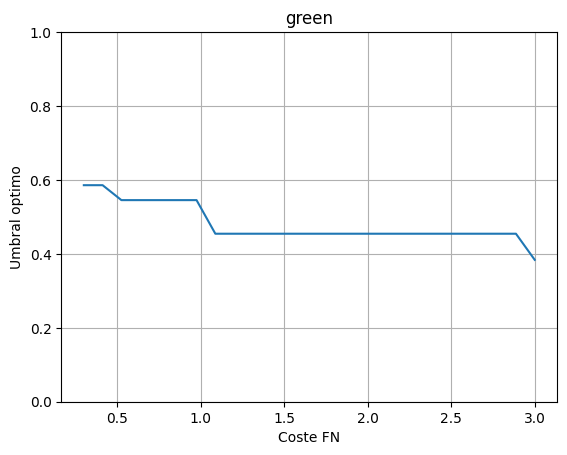

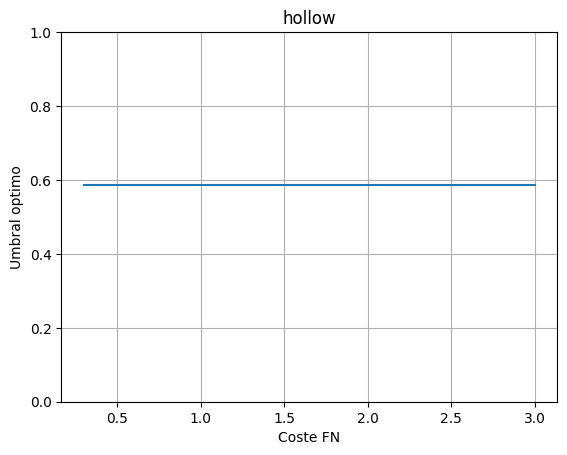

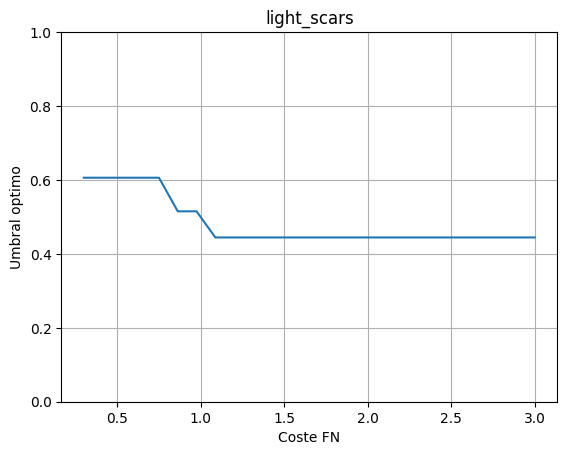

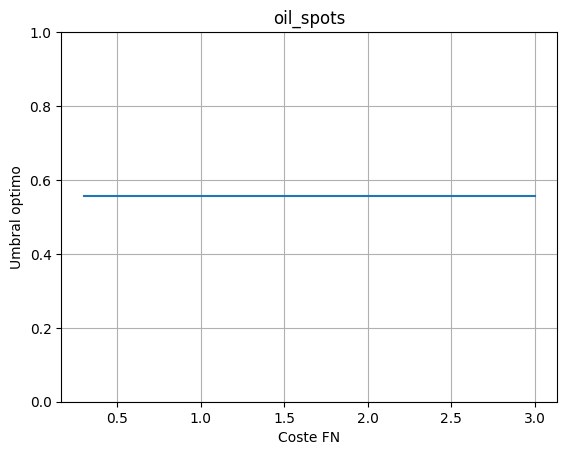

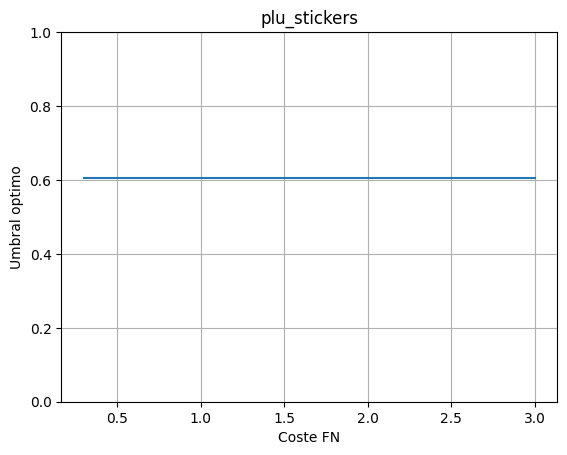

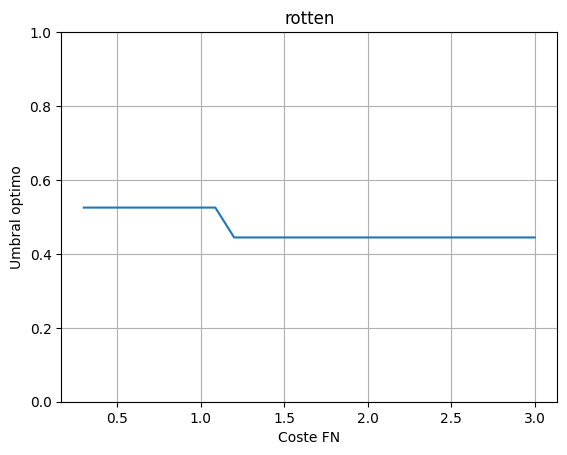

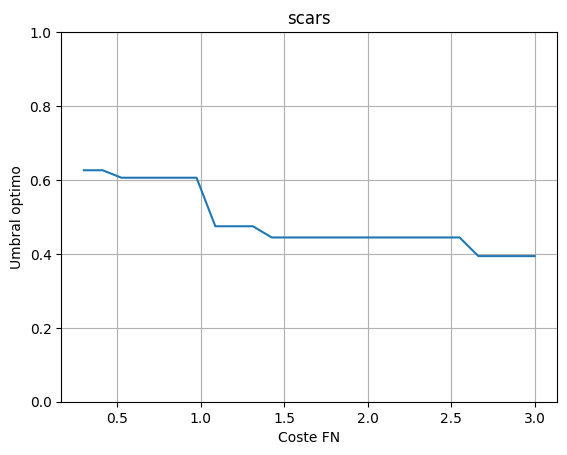

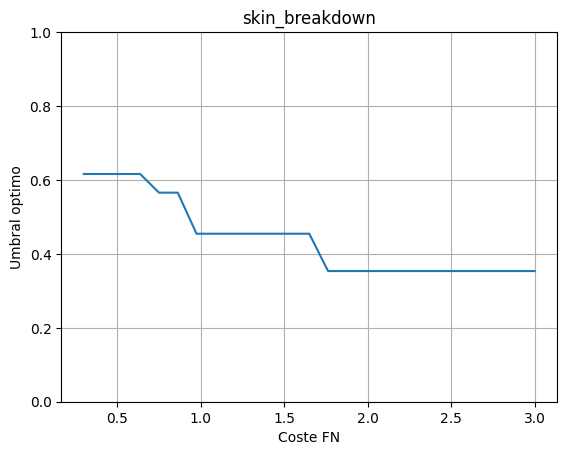

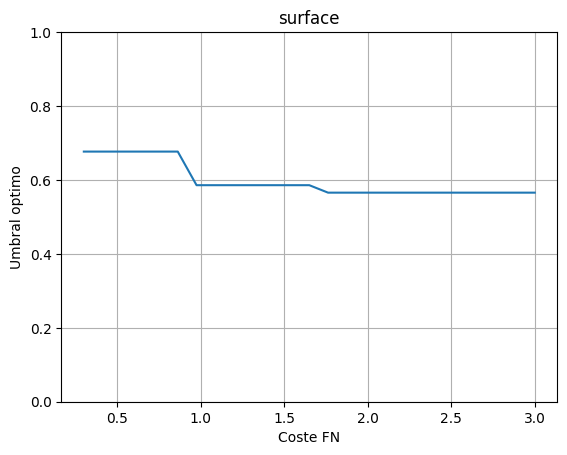

In [38]:
for i in range(ndefectos):
    _=plt.figure()
    plt.plot(costes_falso_negativos, umbrales_clases[i])
    _=plt.xlabel("Coste FN")
    _=plt.ylabel("Umbral optimo")
    _=plt.title(f"{clases[i] }")
    _=plt.ylim(0,1)
    _=plt.grid()
